In [6]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import math

#### Parameters 

In [52]:
kClb1s = 0.002
kClb1sp = 0.2
kClb1spp = 0.1
kClb1d = 0.1
kClb1dp = 0.2
kClb1dpp = 0.02

kClb3s = 0.002
kClb3sp = 0.5
kClb3d = 0.2
kClb3Cdc20d = 0.2

kCdc20s = 0.2
kCdc20d = 0.1
kCdc20Clb1p = 0.1
kCdc20Clb3p = 0.1
kCdc20a = 0.1
JCdc20Clb3 = 0.1
JCdc20clb1 = 0.1
JCdc20 = 0.1
kClb1Cdc20d = 0.05
kClb3Cdc20d = 0.05

kClb4s = 0.2
kClb4sp = 0.1
kClb4d = 0.2
kClb4dp = 1
kClb4dpp = 0.02

kSPa = 2
kSPi = 2
JSP = 0.01

kCdc5s = 0.004
kCdc5sp = 0.03
kCdc5spp = 0.02
kCdc5d = 0.02
kCdc5dp = 0.06
kCdc5dpp = 0.002
kCdc5a = 0.1
kCdc5ap = 0.4
kCdc5app = 0.3
kCdc5i = 0.1

kNdd1s = 0.03
kNdd1d = 0.0001
kNdd1dp = 1
kNdd1dpp = 0.02
kNdd1a = 0.1
kNdd1ap = 0.2
kNdd1app = 0.04
kNdd1i = 0.2
JNdd1 = 0.04

kHcm1d = 0.02

kNdt80s = 0.01
kNdt80sp = 2
kNdt80d = 0.4
kNdt80dp = 0.1
JNdt80p = 0.2
alpha = 1
beta = 0.1
ki = 0.01

kSum1i = 0.025
kSum1a = 0.000001
kSum1ip = 0.1
kSum1ipp = 1
kSum1ap = 0.01
kSum1ippp = 0.25
kSum1app = 1

kAma1a = 0.1
kAma1i = 0.0
kAma1ip = 0.1
JAma1 = 0.1
kAIas = 10
kAIds = 1
kAma1clb3p = 0.1

kAIs = 0.1
kAId = 0.15

kRCa = 1
kRCi = 0.1
kRCip = 2
JRC = 0.01

kAma1s = 0.01
kAma1dp = 0.01

#### ODE System

In [71]:
# p is the ODE system vector p=[f1, f2, f3, f4, ..., f19]
# 0  -> clb1
# 1  -> clb3
# 2  -> cdc20T
# 3  -> cdc20
# 4  -> clb4
# 5  -> sp
# 6  -> cdc5t
# 7  -> cdc5a 
# 8  -> ndd1t
# 9  -> ndd1a
# 10 -> hcm1
# 11 -> ndt80
# 12 -> sum1iIme2
# 13 -> sum1iCdk1
# 14 -> sum1iRC
# 15 -> ama1p
# 16 -> rc
# 17 -> dsb
# 18 -> ama1t

def ode_system(p,t):
    # time functions
    kDSBi = 0.02
    Sum1T = 1
    Dmc1 = 1
    Sum1I = lambda t: p[12]*p[13]*p[14]/(Sum1T * Sum1T)
    JNdt80 = lambda t: JNdt80p*(1+(alpha*(Sum1T-p[12])+beta*(p[12]-Sum1I(t)))/ki)
    Ama1 = lambda t: p[18]-p[15]
    Rim4 = lambda t: (1-math.tanh(0.2*(t-240)))/2
    
    # system equations
    clb1_dt = kClb1s+kClb1sp*p[11]-(kClb1d+kClb1dp*Ama1(t)+kClb1Cdc20d*p[3])*p[0]
    clb3_dt = kClb3s-(kClb3d+kClb3Cdc20d*p[3])*p[1]+5*kClb3sp*(1-Rim4(t))*math.exp(-(t-240)/25)
    cdc20T_dt = kCdc20s-kCdc20d*p[2]
    cdc20_dt = kCdc20Clb1p*p[0]*(p[2]-p[3])/(JCdc20clb1+p[2]-p[3])+kCdc20Clb3p*p[1]*(p[2]-p[3])/(JCdc20Clb3+p[2]-p[3])-kCdc20a*p[3]/(JCdc20+p[3])-kCdc20d*p[3]
    clb4_dt = kClb4s+kClb4sp*p[11]-(kClb4d+kClb4dp*Ama1(t))*p[4]
    sp_dt = kSPa*(p[0]+p[4])*((1-p[5])/(JSP+1-p[5]))-kSPi*p[5]/(JSP+p[5])
    cdc5t_dt = kCdc5s+kCdc5sp*p[11]-(kCdc5d+kCdc5dp*Ama1(t))*p[6]
    cdc5a_dt = (kCdc5a+kCdc5ap*p[0]+kCdc5app*p[4])*(p[6]-p[7])-kCdc5i*p[7]-(kCdc5d+kCdc5dp*Ama1(t))*p[7]
    ndd1t_dt = 0
    ndd1a_dt = 0
    hcm1_dt = -kHcm1d*p[10]
    ndt80_dt = kNdt80s+kNdt80sp*p[11]/(JNdt80(t)+p[11])-kNdt80d*p[11]-kNdt80dp*Ama1(t)*p[11]
    sum1iIme2_dt = kSum1i*(Sum1T-p[12])-kSum1a*p[12]
    sum1iCdk1_dt = (kSum1ip+kSum1ipp*(p[0]+p[4]))*(Sum1T-p[13])-kSum1ap*p[13]
    sum1iRC_dt = kSum1ippp*(Sum1T-p[14])-kSum1app*p[16]*p[14]
    ama1p_dt = (kAma1i+kAma1ip*p[0])*(p[18]-p[15])/(JAma1+p[18]-p[15])-kAma1a*p[15]/(JAma1+p[15])+kAma1clb3p*p[1]*(p[18]-p[15])/(JAma1+p[18]-p[15])
    rc_dt = kRCa*p[17]*(1-p[16])/(JRC+1-p[16])-(kRCi+kRCip*p[7])*p[16]/(JRC+p[16])
    dsb_dt = -kDSBi*p[17]*Dmc1
    ama1t_dt = (kAma1s-kAma1dp*p[18])+40*kAma1s*(1-Rim4(t))*math.exp(-(t-240)/100)
    return clb1_dt,clb3_dt,cdc20T_dt,cdc20_dt,clb4_dt,sp_dt,cdc5t_dt,cdc5a_dt,ndd1t_dt,ndd1a_dt,hcm1_dt,ndt80_dt,sum1iIme2_dt,sum1iCdk1_dt,sum1iRC_dt,ama1p_dt,rc_dt,dsb_dt,ama1t_dt

#### Initial conditions for p vector and time range

In [128]:
p_init = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0]
time = np.arange(0,660)

#### Use scipy odeint to get the determinitstic solution by numerically intergrating the ODE system

In [94]:
p_t = odeint(func=ode_system, y0=p_init, t=time)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


#### Visualize deterministic solutions

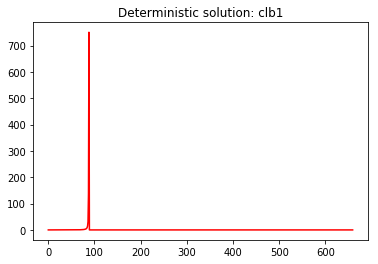

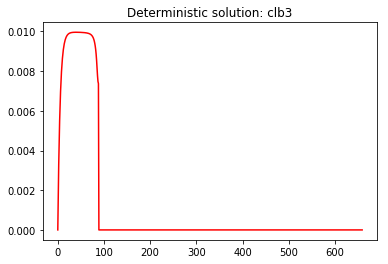

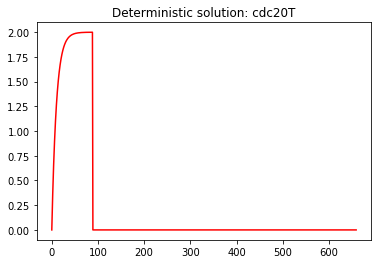

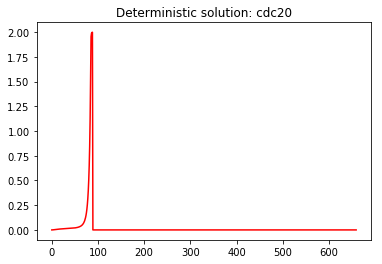

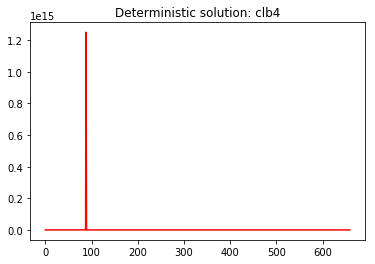

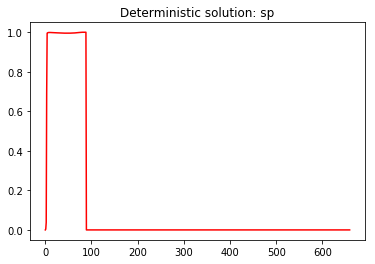

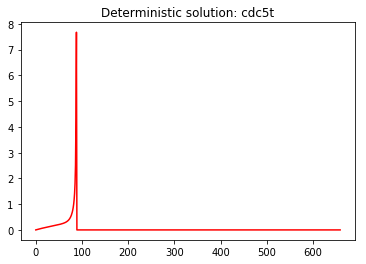

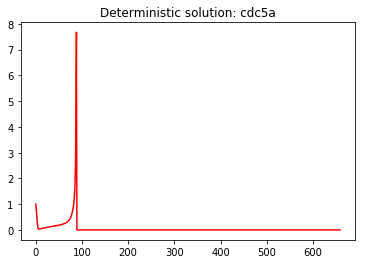

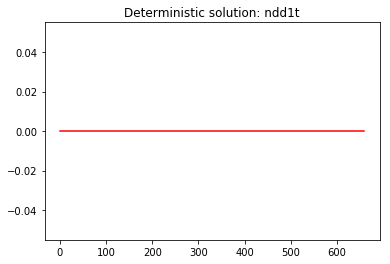

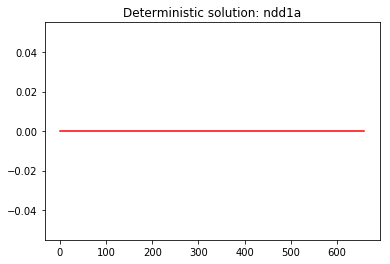

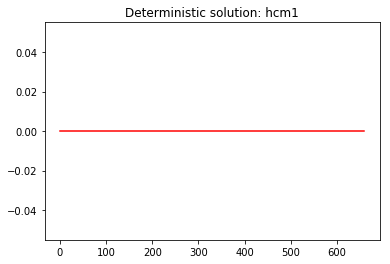

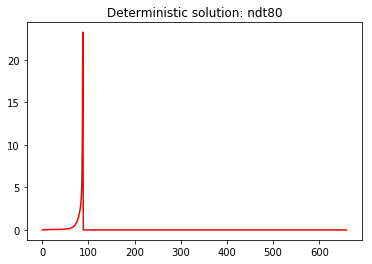

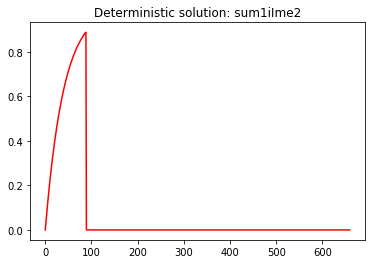

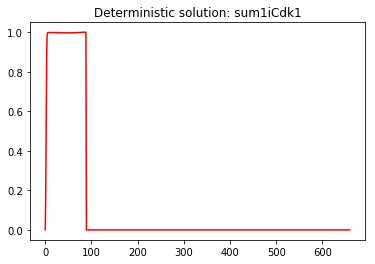

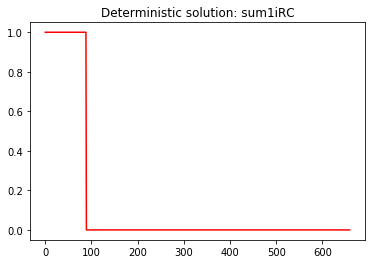

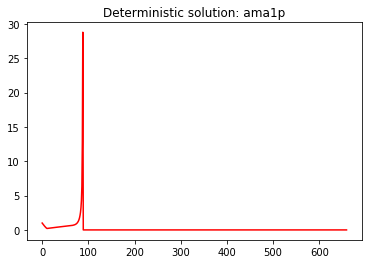

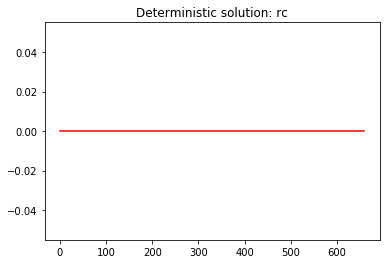

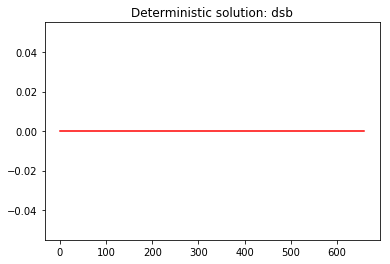

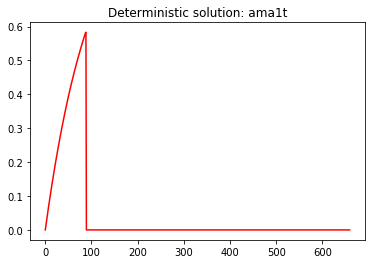

In [127]:
names = ['clb1','clb3','cdc20T','cdc20','clb4','sp','cdc5t','cdc5a','ndd1t','ndd1a','hcm1','ndt80','sum1iIme2','sum1iCdk1','sum1iRC','ama1p','rc','dsb','ama1t']
for j in range(0,19):
    points = []
    for i in range(0, p_t.shape[0]):
        points.append(p_t[i][j])
    plt.plot(time, points, color='r')
    plt.title('Deterministic solution: ' + names[j])
    plt.show()